# Intervalo superior para Poisson con errores sistemáticos

In [9]:
import matplotlib.pyplot as plt
import numba
import numpy as np
from scipy.stats import binom, poisson
from scipy.optimize import minimize, root_scalar

plt.rc("figure", dpi=100)


El experimento consiste en medir una señal $s$, en presencia de una señal de fondo $b$ y teniendo en cuenta que el detector tiene una eficiencia $e$.

La distribución $P(n)$ de la cantidad $n$ de eventos esperada se puede modelar como una Poisson $P(n \,|\, \mu)$ de parámetro $\mu = e (s + b)$.

El fondo y la eficiencia se determinaron en experimentos independientes, donde se observaron $b_{obs}$ eventos para el fondo, y se midieron $e_{obs}$ de $e_{tot}$ para determinar la eficiencia del detector.

La verosimilitud del experimento se puede escribir como:

$$\mathcal{L}\Big(n_{obs}, b_{obs}, e_{obs}, e_{tot} \,|\, s, b, e\Big)
= \text{Poisson}\Big(n_{obs} \,|\, e (s + b)\Big)
+ \text{Poisson}\Big(b_{obs} \,|\, b\Big)
+ \text{Binomial}\Big(e_{obs} \,|\, p=e, N=e_{tot} \Big)
$$

En el experimento en cuestión, no se observaron eventos, $n = 0$, y queremos dar una cota superior para el parámetro $s$.

## Parámetros

In [10]:
CL = 0.95
s = np.linspace(0, 2.8, 100)

# Observado
n_obs = 0

# Background
b_obs = 3

# Eficiencia
e_obs = 99
e_tot = 100

# Estimador de la eficiencia
e_hat = e_obs / e_tot


## Método híbrido frecuentista-bayesiano (Cousins-Highland)

Una opción consiste en integrar los parámetros *molestos*, $b$ y $e$, utiliznado Bayes:

$$ P\Big(n \,|\, s \Big) \propto \int \mathcal{L}\Big(n, ... \,|\, s, b, e\Big) \, \pi(b) \, \pi(e) \; db \, de $$

Luego, buscamos $s_{max}$ tal que $P(n \leq n_{obs} \,|\, s) = 1 - \text{CL}$.

Para hacer esta integral, utilizamos Monte Carlo, donde vamos tomando muestras de los *priors* para $e$ y $b$.

In [11]:
@numba.njit
def sample_n(s, background_dist, efficiency_dist):
    """Toma muestras de P(n|s) para los dados priors del fondo y la eficiencia."""
    b = background_dist()
    e = efficiency_dist()
    mu = e * (s + b)
    return np.random.poisson(mu)


@np.vectorize
@numba.njit(parallel=True)
def prob_less_eq(n_obs: int, s: float, *, background_dist, efficiency_dist, n_exp):
    count = 0
    for _ in numba.prange(n_exp):
        if sample_n(s, background_dist, efficiency_dist) <= n_obs:
            count += 1
    return count / n_exp


## Perfilado frecuentista

La opción frecuentista consiste en hacer lo que se conoce como perfilado. Se busca el $s_{max}$ utilizando la verosimilitud como si fuese únicamente una función de la señal $s$, mientras que a los parámetros $b$ y $e$ se los evalua en los máximos locales para ese dado $s$:

$$ \mathcal{L}_p(n_{obs} \,|\, s) \equiv \mathcal{L}\Big(n_{obs}, ... \,|\, s, \hat{b}(s), \hat{e}(s)\Big) $$

Luego, normalizando la verosimilitud perfilada, se busca $s_{max}$ tal que

$$ \sum_n^{n_{obs}} \mathcal{L}_p(n \,|\, s_{max}) = CL $$

In [12]:
def fix_observed(*, b_obs, e_obs, e_tot):
    """Devuelve el likelihood como función de los parámetros a perfilar
    fijando las variables medidas.
    """

    def likelihood(params, s, n_obs):
        """Log-likelihood del experimento.

        Parameters
        ----------
        params : np.ndarray
            (eficiencia, background)
        """
        e, b = params
        LL_efficiency = binom.logpmf(e_obs, n=e_tot, p=e)
        LL_background = poisson.logpmf(b_obs, mu=b)
        LL_experiment = poisson.logpmf(n_obs, mu=e * (s + b))
        return -2 * (LL_experiment + LL_background + LL_efficiency)

    return likelihood


@np.vectorize
def probabilidad_perfilado(s, n_obs, likelihood, *, e_0, b_0):
    """Devuelve la probabilidad del n_obs.

    Parameters
    ----------
    e_0, b_0 : float
        Parámetros iniciales para la eficiencia y el fondo.
    """
    # Perfilado
    e, b = minimize(
        likelihood, (e_0, b_0), args=(s, n_obs), bounds=[(0, 1), (0, np.inf)]
    ).x
    return poisson.cdf(n_obs, e * (s + b))


def upper_limit_perfilado(n_obs, likelihood, *, e_0, b_0, CL):
    """Calcula el upper limit.

    Parameters
    ----------
    e_0, b_0 : float
        Parámetros iniciales para la eficiencia y el fondo.
    """
    alpha = 1 - CL

    def prob_CL(s):
        prob = probabilidad_perfilado(s, n_obs, likelihood, e_0=e_0, b_0=b_0)
        return prob - alpha

    return root_scalar(prob_CL, method="toms748", bracket=[0, 10]).root


## Comparación

Vamos a comparar el *approach* frecuencista por perfilado con el bayesiano, y un tercero bayesiano, donde reemplazamos los posteriors *Gamma* y *Beta* por gaussianas truncadas en 0.

In [13]:
def fix_parameter(dist, *params):
    """Fija los parámetros de la distribución."""

    def sample():
        return dist(*params)

    return numba.njit(sample)


@numba.njit
def truncated_gaussian(mu, sigma):
    """Gaussiana truncada en 0."""
    while True:
        s = np.random.normal(mu, sigma)
        if s >= 0:
            return s


### Cálculo perfilado

In [14]:
likelihood = fix_observed(b_obs=b_obs, e_obs=e_obs, e_tot=e_tot)
prob_perfilado = probabilidad_perfilado(s, n_obs, likelihood, e_0=e_hat, b_0=b_obs)
upper_lim_perfilado = upper_limit_perfilado(
    n_obs, likelihood, e_0=e_hat, b_0=b_obs, CL=CL
)


### Cálculo híbrido

In [15]:
n_exp = int(3e5)

prob_poisson = prob_less_eq(
    n_obs,
    s,
    background_dist=fix_parameter(np.random.gamma, 1 + b_obs, 1),
    efficiency_dist=fix_parameter(np.random.beta, 1 + e_obs, 1 + e_tot - e_obs),
    n_exp=n_exp,
)
upper_lim_poisson = np.interp(1 - CL, prob_poisson[::-1], s[::-1])

prob_gaussian = prob_less_eq(
    n_obs,
    s,
    background_dist=fix_parameter(truncated_gaussian, b_obs, np.sqrt(b_obs)),
    efficiency_dist=fix_parameter(
        truncated_gaussian, e_hat, np.sqrt(e_hat * (1 - e_hat) / e_tot)
    ),
    n_exp=n_exp,
)
upper_lim_gauss = np.interp(1 - CL, prob_gaussian[::-1], s[::-1])


### Grafico

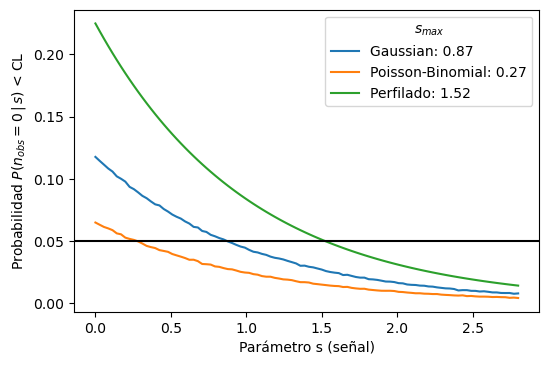

In [16]:
fig, ax = plt.subplots()

ax.plot(s, prob_gaussian, label=f"Gaussian: {upper_lim_gauss:.2f}")
ax.plot(s, prob_poisson, label=f"Poisson-Binomial: {upper_lim_poisson:.2f}")
ax.plot(s, prob_perfilado, label=f"Perfilado: {upper_lim_perfilado:.2f}")
ax.axhline(1 - CL, color="k")

ax.legend(title="$s_{max}$")
ax.set(
    xlabel="Parámetro s (señal)",
    ylabel=f"Probabilidad $P(n_{{obs}}={n_obs} \\,|\\, s)$ < CL",
)

plt.show()
